# TP : Reconstruction of NMR signals

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import scipy
from scipy.sparse.linalg import LinearOperator, bicg
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
import time

# I Introduction

This notebook illustrates the applicability of the presented optimization tools in a problem of signal restoration in nuclear magnetic resonance (NMR). The measurement of diffusion by NMR is used in various application fields (agroalimentary sector, pharmaceutical industry, ecology) to analyze the properties of complex chemical mixtures in order to determine their molecular structure and dynamics. After the immersion of the matter in a strong magnetic field, all the nuclear spins align to an equilibrium state along the field orientation. The application of a short magnetic pulse, i.e. the pulsed field gradient, in resonance with the spin motion disturbs the spin orientation. NMR aims at analyzing the process which corresponds to the re-establishment of the spin into its equilibrium state. During the DOSY (Diffusion Order SpectroscopY) experiment, a series of measurements is acquired for different pulsed field gradient strengths. The data are then analyzed with the aim to separate different species according to their diffusion coefficient. 

## I-1 Observation model

The DOSY NMR data $\mathbf{y}= (y^{(m)})_{1 \leq m \leq M} \in \mathbb{R}^{M}$ gathers the results of $M$ experiments characterized by a vector $\mathbf{t} = (t^{(m)})_{1 \leq m \leq M} \in \mathbb{R}^M$ related to the pulsed field gradient strength and to the acquisition time. The relation between $\mathbf{y}$ and $\mathbf{t}$ can be expressed as the following Laplace transform:
\begin{equation}
(\forall m \in \{1,\ldots,M\}) \quad y^{(m)} = \int \chi(T) \exp(- t^{(m)} T ) dT, \label{eq:lapl}
\end{equation}
where $\chi(T)$ is the unknown diffusion distribution. The problem is then to reconstruct $\chi(T)$ on the sampled grid $\mathbf{T} = (T^{(n)})_{1 \leq n \leq N}$, from the measurements $\mathbf{y}$. After discretization and appropriate normalization, 
the observation model reads
\begin{equation}
\mathbf{y} = \mathbf{H} \overline{\mathbf{x}} + \mathbf{w}, \label{eq:model}
\end{equation}
where $\mathbf{H} \in \mathbb{R}^{M \times N}$ is given by
\begin{equation}
(\forall m \in \{1,\ldots,M\}) (\forall n \in \{1,\ldots,N\}) \qquad H^{(m,n)} = \exp(-T^{(n)} t^{(m)}), \label{eq:K}
\end{equation}
$\overline{\mathbf{x}}  \in \mathbb{R}^N$ is the sought signal related to $\left(\chi(T^{(n)})\right)_{1 \leq n \leq N}$ (up to a scaling factor depending on the discretization grid), and $\mathbf{w} \in \mathbb{R}^M$ is a perturbation noise.

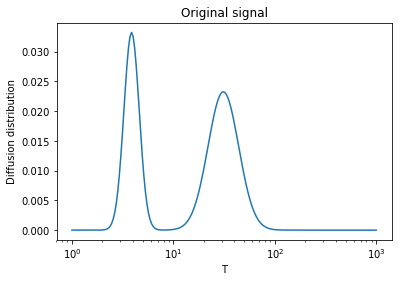

In [3]:
x_bar = np.loadtxt("signal.txt").flatten()
Tmin  = 1
Tmax  = 1000
N     = 200
T     = Tmin*np.exp(-(np.arange(N))*np.log(Tmin/Tmax)/(N-1))
plt.semilogx(T,x_bar)
plt.xlabel("T")
plt.ylabel("Diffusion distribution")
plt.title("Original signal")
plt.show()

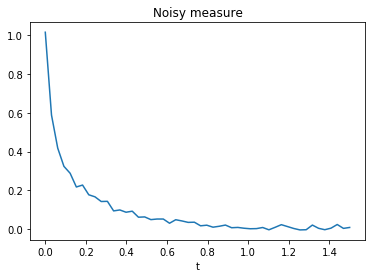

In [4]:
tmin = 0
tmax = 1.5
M    = 50
np.random.seed(1)
t     = tmin + np.arange(M)*(tmax-tmin)/(M-1)
H     = np.exp(-t.reshape(-1,1)@T.reshape(-1,1).T)
z     = H@x_bar.reshape(-1,1)
noise = np.random.normal(0, 0.01*z[0], size=(M,1))
y     = z + noise
plt.title("Noisy measure")
plt.xlabel("t")
plt.plot(t,y)
plt.show()

## I-2 Problem statement

We propose here to find an estimate $\widehat{\mathbf{x}} \in \mathbb{R}^N$ of $\overline{\mathbf{x}}$ by solving the following minimization problem, requiring the knowledge of $\mathbf{H}$ and $\mathbf{y}$:
\begin{equation}
\text{minimize}_{\mathbf{x} \in \mathbb{R}^N} \frac{1}{2} \| \mathbf{H} \mathbf{x} - \mathbf{y} \|^2 + \beta g(\mathbf{x}) \label{eq:pb_rmn}
\end{equation}
where $g \in \Gamma_0(\mathbb{R}^N)$ denotes a regularization term and $\beta > 0$ is a regularization parameter. 

Note that, in practice, a very large number of DOSY NMR acquisitions (typically, $10^4$) are made for various settings of the pulsed gradient field, 
so that the optimization problem must be solved many times, which motivates the search for a fast minimization algorithm. 

In the following, you will implement optimization solutions, for various choices of function $g$ listed below:

*   Quadratic penalization
*   Quadratic penalization + range constraint
*   L1 penalization 
*   Smoothed L1 penalization 

# II Comparison of regularization strategies

## II-1 Quadratic penalization

Let us start with the following regularization term serving to promote the reconstruction of smooth signals:

$g(\mathbf{x}) = \frac{1}{2} \| \mathbf{D}  \mathbf{x}\|^2$

with $\mathbf{D} \in \mathbb{R}^{N \times N}$ is the discrete gradient operator such that, 
\begin{equation}
(\forall n \in \left\{1,\ldots,N\right\}) \quad [\mathbf{D} \mathbf{x} ]^{(n)} = x^{(n)} -  x^{(n-1)}
\end{equation}
with the circular convention $x^{(0)} = x^{(N)}.$

In [5]:
D = np.eye(N)+ -np.roll(np.eye(N), 1, axis=0)
def error(x_hat):
    return norm(x_bar.flatten() - x_hat.flatten())**2/norm(x_bar.flatten())**2

In this case, the problem has an explicit solution given by :

$ \widehat{\mathbf{x}} = (\mathbf{H}^T \mathbf{H}+\beta \mathbf{D}^T \mathbf{D})^{-1} \mathbf{H}^T \mathbf{y} $ 

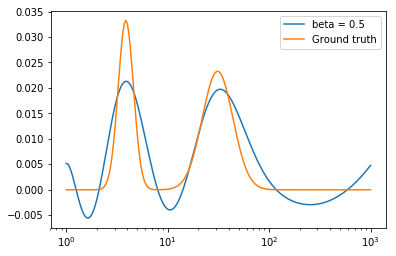

Error(beta = 0.5) = 0.1736648558693157


In [7]:
beta  = 0.5
x_hat = np.linalg.inv(H.T@H+beta*D.T@D)@H.T@y
plt.semilogx(T,x_hat,label="beta = {}".format(beta))
plt.semilogx(T,x_bar, label="Ground truth")
plt.legend()
plt.show()

print("Error(beta = {}) = {}".format(beta,error(x_hat)))

## II-2 Quadratic penalization + range constraints

Now, assume that we want to impose some value range constraints on the sought signal. Then a possible regularization function is:
\begin{equation}
(\forall \mathbf{x} \in \mathbb{R}^N) \quad g(\mathbf{x}) = \frac{1}{2} \| \mathbf{D} \mathbf{x}\|^2 + \iota_{[x_{\min},x_{\max}]^N}(\mathbf{x})
\end{equation}
with $0 \leq x_{\min} < x_{\max}$ the sought minimum and maximum values of the signal. 

For this setting, we can obtain $\widehat{\mathbf{x}}$ using the projected gradient method. 

In [10]:
xmin  = min(x_bar)
xmax  = max(x_bar)
cost  = lambda x,b: 0.5*np.linalg.norm(H@x-y)**2 +0.5*b*np.linalg.norm(D@x)**2

def projected_grad_solver(beta,verbose=False):
    Grad     = H.T@H+beta*D.T@D
    nu       = max(np.abs(np.linalg.eigvals(Grad)))
    gamma    = 1.999/nu
    delta    = 2 - gamma*nu/2
    lambda_n = 0.99*delta

    tol     = 3e-6
    x_0     = np.ones((N,1))
    x_n_new = x_0
    x_n     = x_0
    n_iter  = 0
    start   = True
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, cost(x_n,beta)])

    while start or np.linalg.norm(x_n-x_n_new)/np.linalg.norm(x_n)> tol:
        start   = False
        x_n     = x_n_new
        y_n     = x_n -gamma*(Grad@x_n - H.T@y)
        x_n_new = x_n + lambda_n*(np.clip(y_n,xmin,xmax)-x_n)
        history.append([time.time() - t_0, cost(x_n,beta)])
        n_iter += 1 
        if n_iter % 5000 == 0 and verbose:
            print("Error and precision at iteration %d : %.4e  %.4e"%(n_iter, error(x_n_new),np.linalg.norm(x_n-x_n_new)/np.linalg.norm(x_n)))
        if n_iter == 100000:
            break
    print('beta %.4e error %.4e'%(beta,error(x_n_new)))
    return x_n_new, error(x_n_new), np.array(history)




beta 6.2500e-02 error 6.4192e-02
Error(beta = 0.0625) = 0.06419178399677239


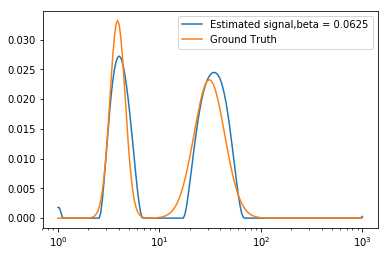

In [11]:
beta         = 0.0625
x_n, error_n, history = projected_grad_solver(beta)
print("Error(beta = {}) = {}".format(beta,error(x_n)))
plt.semilogx(T,x_n, label   = "Estimated signal,beta = {}".format(beta))
plt.semilogx(T,x_bar, label = "Ground Truth")
plt.legend()
plt.show()

No handles with labels found to put in legend.


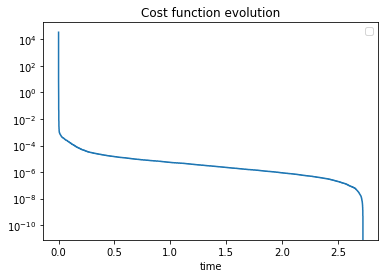

In [12]:
min_objective = np.min(history[:,1])
plt.semilogy(history[:,0],history[:,1]-min_objective)
plt.title("Cost function evolution")
plt.xlabel("time")
plt.legend()
plt.show()

## II-3 Sparsity prior

Another strategy for regularization is to enforce the sparsity of the sought signal. In that respect, one can use
\begin{equation}
(\forall \mathbf{x} \in \mathbb{R}^N) \quad g(\mathbf{x}) =  \|\mathbf{x}\|_1.
\end{equation}

Function $g$ is convex, but it is not differentiable. The problem can be solved using the forward-backward algorithm.

In [13]:
cost  = lambda x,b: 0.5*np.linalg.norm(H@x-y)**2 +b*np.sum(np.abs(x))

def forward_backward(beta, verbose=False):
    prox_abs = lambda x,b: np.sign(x)*np.maximum(np.abs(x)-b,0)

    nu       = max(np.abs(np.linalg.eigvals(H.T@H)))
    gamma    = 1.99/nu
    delta    = 2 - gamma*nu/2
    lambda_n = 0.9*delta

    tol     = 3e-6
    x_0     = np.ones((N,1))
    x_n_new = x_0
    x_n     = x_0
    n_iter  = 0
    start   = True
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, cost(x_n,beta)])
    
    while start or  np.linalg.norm(x_n-x_n_new)/np.linalg.norm(x_n)> tol :
        start   = False
        x_n     = x_n_new
        y_n     = x_n - gamma*(H.T@H@x_n - H.T@y)
        x_n_new = x_n + lambda_n*(prox_abs(y_n,gamma*beta)-x_n)
        history.append([time.time() - t_0, cost(x_n,beta)])
        n_iter += 1
        if n_iter % 40000 == 0 and verbose:
            print("Error and precision at iteration %d : %.4e  %.4e"%(n_iter, error(x_n_new),np.linalg.norm(x_n-x_n_new)/np.linalg.norm(x_n)))
        if n_iter==100000:
            break
    print('Beta %.4e error %.4e'%(beta,error(x_n_new)))
    return x_n, error(x_n_new), np.array(history)  



Beta 1.6000e-03 error 7.6332e-02
Error(beta = 0.0016) = 0.07633186137841315


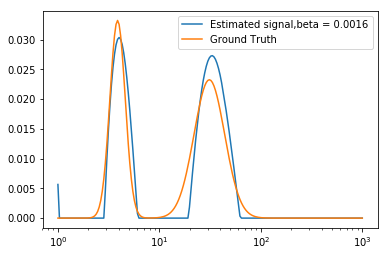

In [14]:
beta  = 0.0016

x_n, error_n, history = forward_backward(beta)
print("Error(beta = {}) = {}".format(beta,error(x_n)))
plt.semilogx(T,x_n, label = "Estimated signal,beta = {}".format(beta))
plt.semilogx(T,x_bar, label = "Ground Truth")
plt.legend()
plt.show()

No handles with labels found to put in legend.


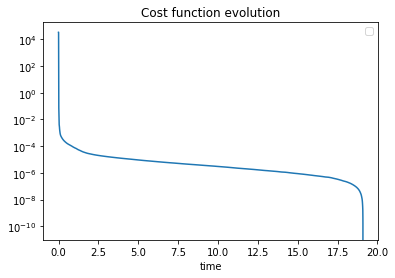

In [15]:
min_objective = np.min(history[:,1])
plt.semilogy(history[:,0],history[:,1]-min_objective)
plt.title("Cost function evolution")
plt.xlabel("time")
plt.legend()
plt.show()

## II-4 Sparsity in a transformed domain

It can finally be useful to impose the sparsity of the signal in a transformed domain, in order to impose some regularity properties. For instance, it can be assumed 
that $\mathbf{D} \overline{\mathbf{x}}$ is sparse:
\begin{equation}
(\forall \mathbf{x} \in \mathbb{R}^N) \quad g(\mathbf{x}) =  \|\mathbf{D} \mathbf{x}\|_1.
\end{equation}

Because of the presence of matrix $\mathbf{D}$, the proximal step in the forward-backward algorithm is not explicit anymore.
We propose two alternative solutions :

* MM quadratic algorithm (considering a smoothed version of the $\ell_1$ norm)
* Primal-dual proximal algorithm

### a) MM algorithm

In [16]:
delta = 5e-3
lbd   = 1e-5

def psi(x, delta=delta): 
    return np.sqrt(1 + np.square(x)/np.square(delta))

def psi_prime(x, delta=delta):
    return x / (np.square(delta) * psi(x))

def r(x):
    return psi(D@x).sum()

def grad_r(x):
    return np.dot(D.T,psi_prime(D@x))

def f(x):
    q = H@x - y
    return 0.5 * q.T.dot(q) + lbd * r(x)

def grad_f(x):
    return H.T@(H@x - y) + lbd * grad_r(x)

In [17]:
# the diagonal matrix for the regularization function potential:
def DD(x):
    x = D@x
    d = 1. / (delta ** 2 * np.sqrt(1 + (x/delta)**2))
    return scipy.sparse.diags(d[:,0]).tocsc()

# Returns a linear operator that does the computation of the curvature of the majorant matrix at some point
def majorant_curve_operator(x_0):
    D_x_0 = DD(x_0)
    def linear_operator(x):
        return H.T.dot(H.dot(x)) + lbd * D.T.dot(D_x_0.dot(D@x))
    return LinearOperator((N,N), matvec=linear_operator, rmatvec=linear_operator)

# we use the constructed functions to implement the following algorithm:
def mm_quadratic(f, grad_f, majorant_curve_operator):
    x_0     = np.ones((N,1))
    theta   = 1
    x_n = x_0
    grad_fx = grad_f(x_n)
    sqr_norm_grad = grad_fx.T.dot(grad_fx)
    it = 0
    
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, f(x_n)])
    
    while sqr_norm_grad > N*1e-8:
        it += 1
         
        # at each iteration solve the linear system instead of inverting the matrix:
        x_n = x_n - theta * bicg(majorant_curve_operator(x_n), grad_fx)[0].reshape(N,1)
        
        grad_fx = grad_f(x_n)
        sqr_norm_grad = grad_fx.T.dot(grad_fx)
        
        if it % 50 == 0:
            print("it ",it,"sqr norm of grad:", sqr_norm_grad[0,0])
            history.append([time.time() - t_0, f(x_n)])
    
    print("Converged in ", str(it), " iterations")
    
    return x_n, np.array(history)

Converged in  2  iterations
Error(lambda = 1e-05, delta = 0.005) = 0.17065419726453698


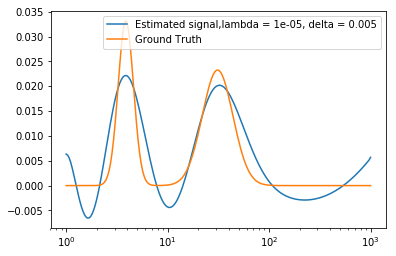

In [18]:
x_n, history = mm_quadratic(f, grad_f, majorant_curve_operator)
print("Error(lambda = {}, delta = {}) = {}".format(lbd,delta,error(x_n)))
plt.semilogx(T,x_n, label = "Estimated signal,lambda = {}, delta = {}".format(lbd,delta))
plt.semilogx(T,x_bar, label = "Ground Truth")
plt.legend()
plt.show()

No handles with labels found to put in legend.


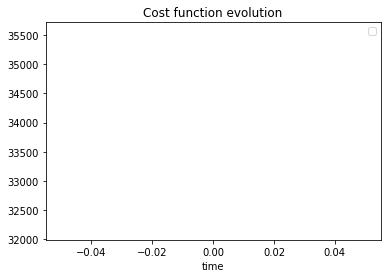

In [19]:
min_objective = np.min(history[:,1])
plt.plot(history[:,0],history[:,1])
plt.title("Cost function evolution")
plt.xlabel("time")
plt.legend()
plt.show()

### b) Primal-dual algorithm

In [20]:
cost  = lambda x,b: 0.5*np.linalg.norm(H@x-y)**2 +b*np.sum(np.abs(D@x))

def primal_dual(beta, verbose=False):
    prox_abs = lambda x,b: np.sign(x)*np.maximum(np.abs(x)-b,0)

    nu       = max(np.abs(np.linalg.eigvals(H.T@H)))
    gamma    = 1
    tau      = 1/nu
     
    tol     = 3e-6
    x_0     = np.ones((N,1))
    x_n_new = x_0
    x_n     = x_0
    y_n     = D@x_0
    n_iter  = 0
    start   = True
    history = []
    t_0 = time.time()
    history.append([time.time() - t_0, cost(x_n,beta)])
    H_inv = np.linalg.inv(tau*H.T@H+np.eye(N))
    
    while start or  np.linalg.norm(x_n-x_n_new)/np.linalg.norm(x_n)> tol :
        start   = False
        x_n     = x_n_new
        x_n_new = np.dot(H_inv,x_n -tau*D.T@y_n + tau*H.T@y)
        v_n = y_n + gamma*np.dot(D,2*x_n_new-x_n)
        y_n = v_n - gamma*(prox_abs(v_n/gamma,beta/gamma))
        history.append([time.time() - t_0, cost(x_n,beta)])
        n_iter += 1
        if n_iter % 1000 == 0 and verbose:
            print("Error and precision at iteration %d : %.4e  %.4e"%(n_iter, error(x_n_new),np.linalg.norm(x_n-x_n_new)/np.linalg.norm(x_n)))
        if n_iter==100000:
            break
    print('Beta %.4e error %.4e'%(beta,error(x_n_new)))
    return x_n, error(x_n_new), np.array(history)  



Error and precision at iteration 1000 : 4.5723e-01  2.9929e-04
Error and precision at iteration 2000 : 3.6805e-01  1.3772e-04
Error and precision at iteration 3000 : 3.2329e-01  8.7032e-05
Error and precision at iteration 4000 : 2.9508e-01  6.8025e-05
Error and precision at iteration 5000 : 2.7580e-01  5.6811e-05
Error and precision at iteration 6000 : 2.6234e-01  4.8144e-05
Error and precision at iteration 7000 : 2.5280e-01  3.9699e-05
Error and precision at iteration 8000 : 2.4595e-01  3.3998e-05
Error and precision at iteration 9000 : 2.4104e-01  2.9709e-05
Error and precision at iteration 10000 : 2.3754e-01  2.6012e-05
Error and precision at iteration 11000 : 2.3508e-01  2.3152e-05
Error and precision at iteration 12000 : 2.3333e-01  2.0441e-05
Error and precision at iteration 13000 : 2.3223e-01  1.8228e-05
Error and precision at iteration 14000 : 2.3147e-01  1.6414e-05
Error and precision at iteration 15000 : 2.3107e-01  1.4862e-05
Error and precision at iteration 16000 : 2.3072e-

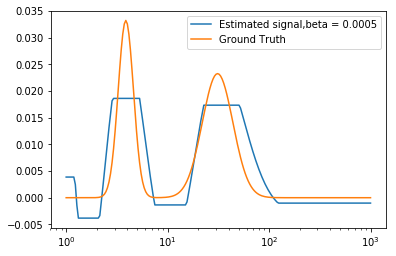

In [21]:
beta  = 5e-4

x_n, error_n, history = primal_dual(beta,verbose = 1)
print("Error(beta = {}) = {}".format(beta,error(x_n)))
plt.semilogx(T,x_n, label = "Estimated signal,beta = {}".format(beta))
plt.semilogx(T,x_bar, label = "Ground Truth")
plt.legend()
plt.show()

No handles with labels found to put in legend.


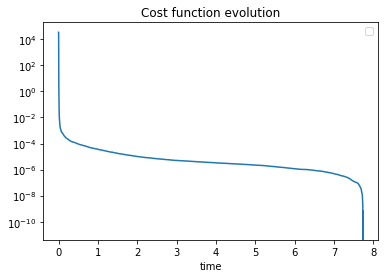

In [22]:
min_objective = np.min(history[:,1])
plt.semilogy(history[:,0],history[:,1]-min_objective)
plt.title("Cost function evolution")
plt.xlabel("time")
plt.legend()
plt.show()

# Bibliography

* C. S. Johnson Jr. Diffusion ordered nuclear magnetic resonance spectroscopy: principles and applications. Progress in Nuclear Magnetic Resonance Spectroscopy, vol. 34, pp. 203–256, 1999.

* A. Cherni, E. Chouzenoux and M.-A. Delsuc. PALMA, an Improved Algorithm for DOSY Signal Processing. Analyst, Vol. 142, No. 5, pages 772-779, 2016.

* N. Komodakis and J.-C. Pesquet. Playing with Duality: An Overview of Recent Primal-Dual Approaches for Solving Large-Scale Optimization problems. IEEE Signal Processing Magazine, vol. 32, no. 6, pp. 31–54, Nov. 2014.

